In [77]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Convert songs in Progressive_Rock_Songs from FLAC and mp3 to .wav format:
def convert_to_wav(dir1):
    for file in os.scandir(dir1):
        out_file = os.path.join(dir1, os.path.splitext(os.path.basename(file.path))[0] + ".wav")
        try:
            AudioSegment.from_file(file.path).export(out_file, format="wav")
            os.remove(file.path)
        except:
            print("skipping" + file.path)

In [ ]:
convert_to_wav('./Progressive_Rock_Songs')

In [ ]:
convert_to_wav('./Not_Progressive_Rock/Other_Songs')
convert_to_wav('./Not_Progressive_Rock/Top_Of_The_Pops')

In [20]:

# Clockwork Angels CNN baseline
def make_mel_spectrogram_df(dir1):

    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    names = []
    # Looping through each file in the directory
    for file in os.scandir(dir1):
        # Loading in the audio file
        y, sr = librosa.core.load(file)

        # Extracting the label and adding it to the list
        names.append(file)
        if 'Not' in dir1:
            labels.append("0")
        else:
            labels.append("1")
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)

        # Adjusting the size to be 128 x 646
        if spect.shape[1] != 646:
            spect.resize(128,646, refcheck=False)

        # Flattening to fit into dataframe and adding to the list
        spect = spect.flatten()
        mel_specs.append(spect)


    # Converting the lists to arrays so we can stack them
    mel_specs = np.array(mel_specs)
    labels = np.array(labels).reshape(len(labels),1)
    names = np.array(names).reshape(len(names),1)
    # print(names)
    # Create dataframe
    df = pd.DataFrame(np.hstack((mel_specs, labels, names)))
    #df.to_csv('mel_train_data.csv', index=False)
    # Returning the mel spectrograms and labels
    return df

In [21]:
df = make_mel_spectrogram_df('./Progressive_Rock_Songs')
df2 = make_mel_spectrogram_df('./Not_Progressive_Rock/Other_Songs')
df3 = make_mel_spectrogram_df('./Not_Progressive_Rock/Top_Of_The_Pops')

In [65]:
frames = [df, df2, df3]
data = pd.concat(frames)
data = data.iloc[: , :-1]

In [66]:
data = data.astype(float)

In [67]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.abs())
data_scaled = pd.DataFrame(data_scaled)

In [24]:
data.to_csv('mel_train_data.csv', index=False)

In [70]:
X = data_scaled.iloc[:, :-1]
X = np.array(X)
X = X.reshape(X.shape[0], 128, 646, 1)
Y = data_scaled.iloc[:, -1]
Y = np.array(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.7, random_state=42)

In [74]:
#Build netowrk architecture
model = keras.Sequential([
        keras.layers.Conv2D(filters = 16,
                         kernel_size = (3,3),
                         activation = "relu",
                         input_shape = (128, 646, 1)),

        keras.layers.MaxPooling2D(pool_size = (2,4)),
        keras.layers.Dropout(0.2),

         keras.layers.Conv2D(filters = 32,
                         kernel_size = (3,3),
                         activation = "relu"),

        keras.layers.MaxPooling2D(pool_size = (2,4)),
        keras.layers.Dropout(0.2),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation = "relu",
                           kernel_regularizer = keras.regularizers.l2(0.001)),

        keras.layers.Dropout(0.3),

        keras.layers.Dense(2, activation = "sigmoid")
        ])
        
#compile network
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [75]:
#train network
model.fit(X_train, Y_train, epochs = 50, batch_size = 32, shuffle=True, class_weight={0: 1, 1: 1.5}, verbose=0)

In [76]:
model.evaluate(X_train, Y_train)
model.evaluate(X_val, Y_val)

3/3 [==============================] - 0s 107ms/step - loss: 0.9166 - accuracy: 0.8313


[0.9166168570518494, 0.8313252925872803]

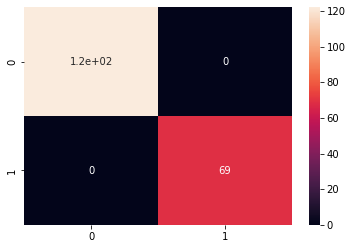

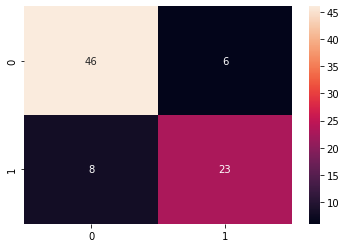

In [81]:
pred_train = model.predict_classes(X_train)
pred_val = model.predict_classes(X_val)

cm0 = confusion_matrix(Y_train, pred_train)
fig0 = plt.figure()
sns.heatmap(cm0, annot=True)
plt.show()

cm1 = confusion_matrix(Y_val, pred_val)
fig1 = plt.figure()
sns.heatmap(cm1, annot=True)
plt.show()